In [1]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [2]:
print(librosa.__version__)
print(soundfile.__version__)
print(sklearn.__version__)

0.10.2.post1
0.12.1
1.3.2


In [2]:
!mkdir ravdess-data
%cd ravdess-data

/content/ravdess-data


In [3]:
# download the dataset from link:
# https://drive.google.com/file/d/1wWsrN2Ep7x6lWqOXfr4rpKGYrJhWc8z7/view

!gdown --id 1wWsrN2Ep7x6lWqOXfr4rpKGYrJhWc8z7
!unzip speech-emotion-recognition-ravdess-data.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1wWsrN2Ep7x6lWqOXfr4rpKGYrJhWc8z7
From (redirected): https://drive.google.com/uc?id=1wWsrN2Ep7x6lWqOXfr4rpKGYrJhWc8z7&confirm=t&uuid=949d4176-39a6-4a18-8269-68dbfab05a8b
To: /content/ravdess-data/speech-emotion-recognition-ravdess-data.zip
100% 78.1M/78.1M [00:02<00:00, 28.8MB/s]
Archive:  speech-emotion-recognition-ravdess-data.zip
   creating: Actor_01/
  inflating: Actor_01/03-01-01-01-01-01-01.wav  
  inflating: Actor_01/03-01-01-01-01-02-01.wav  
  inflating: Actor_01/03-01-01-01-02-01-01.wav  
  inflating: Actor_01/03-01-01-01-02-02-01.wav  
  inflating: Actor_01/03-01-02-01-01-01-01.wav  
  inflating: Actor_01/03-01-02-01-01-02-01.wav  
  inflating: Actor_01/03-01-02-01-02-01-01.wav  
  inflating: Ac

In [4]:
%cd ..

/content


In [10]:
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [6]:
#Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#Emotions to observe - using only sub-part of dataset
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [7]:
for file in glob.glob("ravdess-data/Actor_*[0-9]*/*"):
  file_name = os.path.basename(file)
  print(file_name)

03-01-02-01-02-02-14.wav
03-01-03-02-01-02-14.wav
03-01-05-01-01-02-14.wav
03-01-04-01-02-02-14.wav
03-01-07-02-02-01-14.wav
03-01-07-02-01-02-14.wav
03-01-03-01-01-02-14.wav
03-01-04-01-02-01-14.wav
03-01-08-01-02-02-14.wav
03-01-08-01-02-01-14.wav
03-01-04-01-01-01-14.wav
03-01-01-01-01-02-14.wav
03-01-02-01-02-01-14.wav
03-01-05-01-02-02-14.wav
03-01-07-01-02-01-14.wav
03-01-05-02-02-01-14.wav
03-01-07-01-01-01-14.wav
03-01-08-02-01-01-14.wav
03-01-04-02-02-02-14.wav
03-01-03-01-01-01-14.wav
03-01-06-01-02-02-14.wav
03-01-08-02-02-02-14.wav
03-01-04-02-01-01-14.wav
03-01-03-02-02-02-14.wav
03-01-02-02-02-02-14.wav
03-01-05-02-01-01-14.wav
03-01-02-02-01-02-14.wav
03-01-03-01-02-01-14.wav
03-01-08-01-01-01-14.wav
03-01-06-01-01-01-14.wav
03-01-06-01-01-02-14.wav
03-01-01-01-01-01-14.wav
03-01-08-02-01-02-14.wav
03-01-04-02-01-02-14.wav
03-01-03-02-01-01-14.wav
03-01-07-02-02-02-14.wav
03-01-06-02-01-01-14.wav
03-01-08-02-02-01-14.wav
03-01-06-02-01-02-14.wav
03-01-04-01-01-02-14.wav


In [11]:
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("ravdess-data/Actor_*[0-9]*/*"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)

    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [12]:
#Split the dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.25)

In [13]:
#Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

(576, 192)


In [14]:
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [15]:
#Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [16]:
#Training the model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [17]:
model.score(x_train, y_train)

0.7395833333333334

In [18]:
#Predict for the test set
y_pred=model.predict(x_test)

#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 69.79%


In [19]:
y_pred[:10]

array(['calm', 'calm', 'happy', 'disgust', 'happy', 'calm', 'calm',
       'disgust', 'calm', 'disgust'], dtype='<U7')

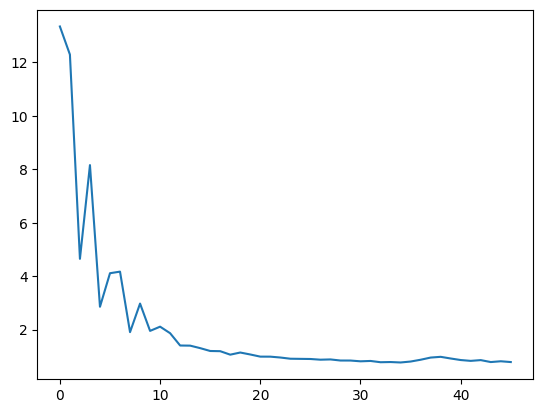

In [20]:
# Plotting graph for MLPClassifier

loss_values = model.loss_curve_
plt.plot(loss_values)
plt.show()

In [21]:
model1=MLPClassifier(alpha=0.001, batch_size=128, hidden_layer_sizes=(200, 200, 100, 50), learning_rate='adaptive', max_iter=500)

#Training the model
model1.fit(x_train,y_train)

model1.score(x_train, y_train)

0.8802083333333334

In [22]:
#Predict for the test set
y_pred1=model1.predict(x_test)

#Calculate the accuracy of our model
accuracy1=accuracy_score(y_true=y_test, y_pred=y_pred1)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy1*100))

Accuracy: 75.00%


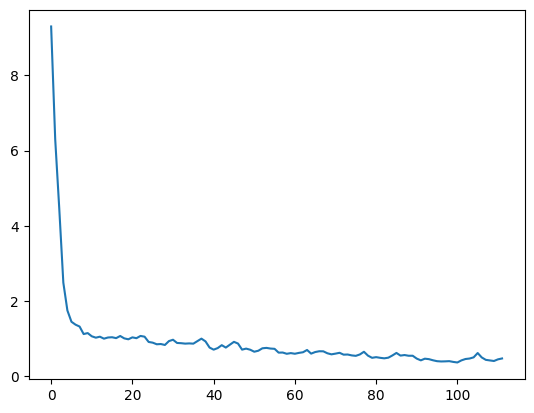

In [23]:
# Plotting graph for MLPClassifier

loss_values1 = model1.loss_curve_
plt.plot(loss_values1)
plt.show()

In [24]:
# Saving the tokenizer and the model:

import pickle

pickle.dump(model1, open('emotion_classification-model.pkl', 'wb'))